## Transcription factor substrate analysis

In this notebook, we look at the results of associating UPS genes with transcription factors.

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import utils

### NFE2L2 proof-of-principle

First, we tested whether we could retreive a known TF, NFE2L2, based on its own degron mutations.

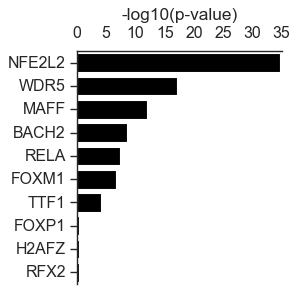

In [2]:
# read in the rabit results
nfe2l2_df = pd.read_csv('data/tf_analysis/nfe2l2_proof_of_principle.txt', sep='\t')
nfe2l2_df.sort_values('pvalue', inplace=True)

# plot significance of top 10 TFs
with sns.axes_style('ticks'), sns.plotting_context('notebook', font_scale=1.3):
    ax = sns.barplot(-np.log10(nfe2l2_df['pvalue'].iloc[:10]), nfe2l2_df['tf'].iloc[:10], 
                     color='black', orient='h')
    ax.tick_params(top=True, bottom=False)
    ax.xaxis.set_ticks_position('top')
    sns.despine(top=False, bottom=True, right=True)
    plt.xlabel('-log10(p-value)')
    ax.xaxis.set_label_position('top')
    plt.ylabel('')
    plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()
    plt.savefig('figures/rabit_nfe2l2.pdf')

### UPS-substrate inference

First, read in the results from the RABIT analysis.

In [3]:
df = pd.read_csv('data/tf_analysis/rabit_formatted_results.txt', sep='\t')

We then process the results.

In [4]:
# SCML2 and ZNF274 were identified as containing poor chip-seq quality and were excluded
not_scml2 = df['tf']!='SCML2'
not_znf274 = df['tf']!='ZNF274'
not_pancan = df['cancer type']!='PANCAN'
filter_flag = not_scml2 & not_znf274 # & not_pancan

# Sort results by significance
df = df[filter_flag].sort_values('pvalue') #.head(100)
df['TF association'] = ''
df['TF association'].iloc[:100] = 'Top 100'
df_top = df.head(100).copy()
df_top.groupby('gene')['tf'].unique().to_clipboard(sep='\t')
df['-log10(p-value)'] = -np.log10(df['pvalue'])

Next, we plot the results of the RABIT analysis.

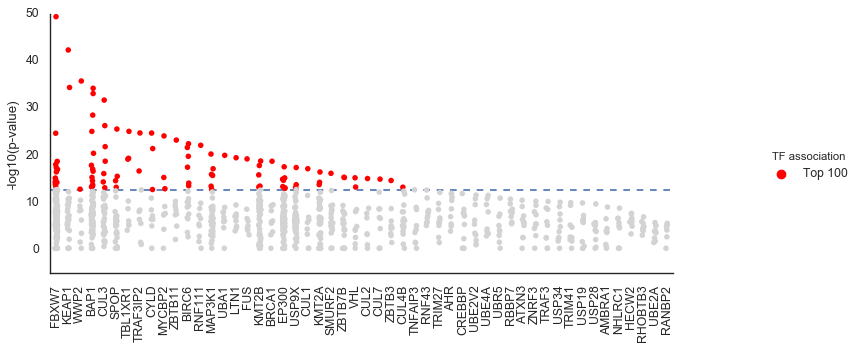

In [5]:
threshold = df['-log10(p-value)'].iloc[100]
with sns.axes_style('white'):
    g = sns.catplot(y="-log10(p-value)", x="gene", data=df, hue='TF association', palette=['red', 'lightgray'])
    #sns.catplot(x="-log10(p-value)", y="gene", data=df_top, color='red', ax=g.ax)
    plt.axhline(threshold, ls='--')
    plt.gca().set_ylim(-5, 50)
    plt.gcf().set_size_inches(12, 4)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.savefig('figures/top100_tf_associations.pdf')

## Suplementary tables

In [13]:
df_top.index = range(len(df_top))
df_top['gene_tf'] = df_top['gene'] + '_' + df_top['tf']
tmp = df_top.drop_duplicates(subset=['gene', 'tf'])
grp = tmp.groupby('gene')
ixs = [i 
       for g in grp.indices 
       for i in grp.indices[g][:5]]
top_assoc = tmp['gene_tf'].iloc[ixs]
df_top_new = df_top.loc[df_top['gene_tf'].isin(top_assoc.values), :].copy()
ub_tf_to_ctype = df_top_new.groupby(['gene', 'tf'])['cancer type'].unique().reset_index()
ub_tf_to_ctype = pd.merge(ub_tf_to_ctype, df_top_new.drop_duplicates('gene_tf')[['gene', 'tf', 'pvalue']],
                          on=['gene', 'tf'], how='left')
ub_tf_to_ctype.sort_values('pvalue', inplace=True)

In [15]:
ub_tf_to_ctype['transcription factor'] = ub_tf_to_ctype['tf'] + ub_tf_to_ctype['cancer type'].apply(lambda x: ' ({})'.format(', '.join(x)))
supp_df = ub_tf_to_ctype.groupby('gene')['transcription factor'].apply(lambda x: '; '.join(x)).loc[df_top['gene'].unique()].reset_index()

In [18]:
supp_df.to_excel('tables/Table1.xlsx', index=False)